In [1]:
pip install pandas numpy matplotlib seaborn nltk wordcloud

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/8d/9d/d06860390f9d154fa884f1740a5456378fb153ff57443c91a4a32bab7092/matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for nltk from https://files.pythonhosted.org/packages/4d/66/7d9e26593edda06e8cb531874633f7c2372279c3b0f46235539fe546df8b/nltk-3.9.1-py3-none-any.whl.metadata
  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/90/be/1a7a488f5edcfae6746ffb91e792a1795b6cc058364ea6888b3878d3476f/wordcloud-1.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/99/e6/d1196696

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# NLTK 데이터 다운로드 (처음 한 번만 실행)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /data/ephemeral/home/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /data/ephemeral/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# CSV 파일로 된 텍스트 데이터 로드 (예: 대화와 요약 데이터)
df = pd.read_csv('/data/ephemeral/home/data/data/dev_en.csv')

# 데이터프레임의 처음 몇 줄 확인
df.head(5)

,fname,dialogue,summary,topic,dialogue_en,summary_en,topic_en
0,dev_400,#Person1#: 업그레이드를 진행하기 위해 회계 시스템을 오프라인으로 전환해야 ...,#Person1#은 업그레이드를 위해 회계 시스템을 오프라인으로 전환해야 한다고 #...,시스템 업그레이드,#Person1#: We need to take the accounting syst...,#Person1# informs #Person2# that the accountin...,System Upgrades
1,dev_401,#Person1#: 실례합니다. 재처방 받길 원합니다.#Person2#: 병에 적혀...,"#Person1#은 처방전을 재처방 받고자 #Person2#에게 요청하지만, 이미 ...",처방전 재처방,#Person1#: Excuse me. I want to get a refill.#...,#Person1# asks #Person2# to refill a prescript...,Prescription refills
2,dev_402,"#Person1#: 자신을 좋은 엄마라고 생각하십니까?#Person2#: 네, 저는...",#Person2#는 #Person2#에게 어떻게 좋은 엄마이자 성공적인 커리어 우먼...,사회 모임,#Person1#: Do you consider yourself a good mot...,#Person2# shares with #Person2# how to be a go...,Social Gatherings
3,dev_403,#Person1#: 이 직책에 자격이 있다고 생각하는 이유는 무엇인가요?#Perso...,"#Person1#이 #Person2#를 인터뷰하고, 자격, 기술적 직위, 원본 자격...",직무 인터뷰,#Person1#: Why do you think you are qualified ...,#Person1# interviewed #Person2# and was provid...,Job Interviews
4,dev_404,"#Person1#: 택시! 택시!#Person2#: 어디로 가시겠습니까, 선생님?#...",#Person1#은 #Person2#의 택시를 타고 기차역으로 갑니다. #Perso...,택시기사와 대화,"#Person1#: Taxi! Taxi!#Person2#: Where to, sir...",#Person1# takes #Person2#'s taxi to the train ...,Talking to a taxi driver


# 마스킹 패턴 찾기

In [4]:
import re
import pandas as pd

def reg_masking(text):
    pattern = r"#\w+#"  # #로 둘러싸인 단어들을 찾는 정규식 패턴
    masked = re.findall(pattern, text)
    return set(masked)  # 중복을 제거하고 고유한 토큰들의 집합을 반환


# `reg_masking`을 호출하고 결과를 문자열로 변환하여 저장
df['masked_patterns'] = df['dialogue_en'].apply(lambda x: str(reg_masking(x)))

# 문자열로 저장된 집합을 실제 집합(set)으로 변환
df['masked_patterns'] = df['masked_patterns'].apply(eval)

# 모든 행에 있는 세트들의 합집합을 구함
all_unique_tokens = set.union(*df['masked_patterns'])

print("고유한 특수 토큰들:", all_unique_tokens)


고유한 특수 토큰들: {'#Person3#', '#Address#', '#Person2#', '#Person4#', '#PhoneNumber#', '#Person1#', '#DateOfBirth#'}


# dialogue, summary 길이

In [6]:
import re
import pandas as pd

# 제거할 특수 토큰 리스트
special_tokens_all = ['#Person3#:', '#Address#', '#Person2#:', '#Person4#:', '#PhoneNumber#', '#Person1#:', '#DateOfBirth#']
special_tokens_n = ['\n']
special_tokens = ['\n', '#Address#', '#PhoneNumber#', '#DateOfBirth#', ':']
speaker_tokens = ['#Person1#:', '#Person2#:', '#Person3#:', '#Person4#:']

# 특수 토큰을 제거하는 함수 정의
def remove_special_tokens(text):
    for token in special_tokens:
        text = text.replace(token, '')  # 특수 토큰을 빈 문자열로 대체
    return text

# 대화의 turn 수를 세는 함수
def count_dialogue_turns(text):
    # 화자 태그 패턴을 정의합니다 (예: #Person1#, #Person2# 등)
    speaker_pattern = r"#Person\d+#"
    
    # 모든 화자 태그를 찾아 리스트로 반환합니다
    speakers = re.findall(speaker_pattern, text)
    
    # 화자가 변경될 때마다 턴을 카운트합니다
    turn_count = 0
    current_speaker = None
    
    for speaker in speakers:
        if speaker != current_speaker:
            turn_count += 1
            current_speaker = speaker
            
    return turn_count

# '\n'을 제거하는 함수 정의
def remove_special_tokens_n(text):
    for token in special_tokens_n:
        text = text.replace(token, '')  # 특수 토큰을 빈 문자열로 대체
    return text

#  제거하는 함수 정의
def remove_speaker_tokens(text):
    for token in speaker_tokens:
        text = text.replace(token, '')  # 특수 토큰을 빈 문자열로 대체
    return text

def count_speakers(text):
    # 화자 식별자에 대한 정규식 패턴 생성
    pattern = r'(' + '|'.join(re.escape(token) for token in speaker_tokens) + ')'
    # 텍스트에서 패턴에 매칭되는 모든 항목을 찾아 집합으로 변환
    speakers = set(re.findall(pattern, text))
    # 집합의 크기(고유 화자 수) 반환
    return len(speakers)

# 대화 및 요약에서 특수 토큰을 제거한 텍스트 생성
df['cleaned_dialogue'] = df['dialogue_en'].apply(remove_special_tokens_n)
df['cleaned_summary'] = df['summary_en'].apply(remove_special_tokens_n)

# 대화의 turn 수 계산
df['dialogue_turns'] = df['dialogue_en'].apply(count_dialogue_turns)
df['number_of_speakers'] = df['dialogue_en'].apply(count_speakers)

# 텍스트 길이 계산
df['cleaned_dialogue2'] = df['cleaned_dialogue'].apply(remove_speaker_tokens)
df['text_length'] = df['cleaned_dialogue2'].apply(len)
df['summary_length'] = df['cleaned_summary'].apply(len)

# 텍스트 길이 및 turn 수, 화자 수 통계 출력
print(df[['dialogue_turns', 'number_of_speakers','text_length', 'summary_length']].describe())


       dialogue_turns  number_of_speakers  text_length  summary_length
count      499.000000          499.000000   499.000000      499.000000
mean         9.358717            2.012024   609.104208      130.739479
std          4.002707            0.126172   330.682568       59.692185
min          2.000000            2.000000   158.000000       33.000000
25%          6.000000            2.000000   376.500000       86.500000
50%          9.000000            2.000000   539.000000      118.000000
75%         12.000000            2.000000   771.000000      158.500000
max         29.000000            4.000000  2288.000000      418.000000


In [7]:
df[['dialogue_turns', 'number_of_speakers','text_length', 'summary_length']].describe()

,dialogue_turns,number_of_speakers,text_length,summary_length
count,499.000000,499.000000,499.000000,499.000000
mean,9.358717,2.012024,609.104208,130.739479
std,4.002707,0.126172,330.682568,59.692185
min,2.000000,2.000000,158.000000,33.000000
25%,6.000000,2.000000,376.500000,86.500000
50%,9.000000,2.000000,539.000000,118.000000
75%,12.000000,2.000000,771.000000,158.500000
max,29.000000,4.000000,2288.000000,418.000000


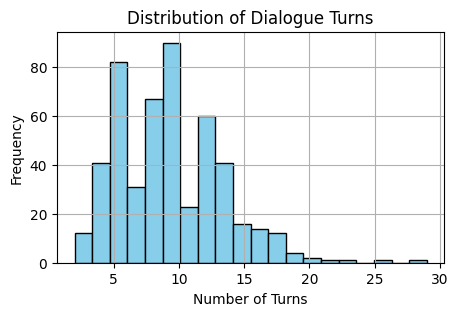

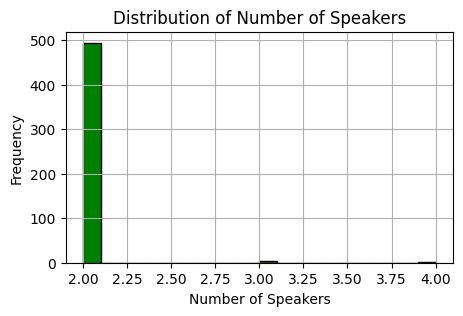

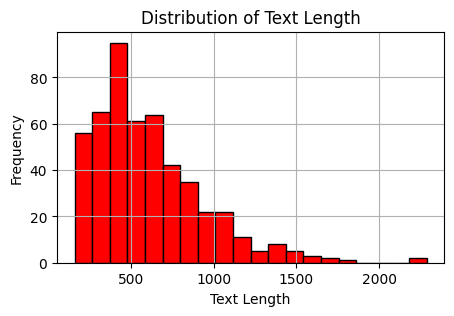

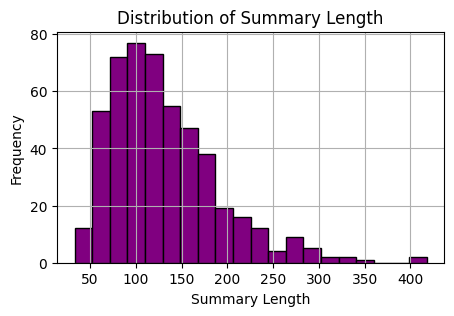

In [8]:
import matplotlib.pyplot as plt

# 'dialogue_turns'의 히스토그램
plt.figure(figsize=(5, 3))
plt.hist(df['dialogue_turns'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Dialogue Turns')
plt.xlabel('Number of Turns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 'number_of_speakers'의 히스토그램
plt.figure(figsize=(5, 3))
plt.hist(df['number_of_speakers'], bins=20, color='green', edgecolor='black')
plt.title('Distribution of Number of Speakers')
plt.xlabel('Number of Speakers')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 'text_length'의 히스토그램
plt.figure(figsize=(5, 3))
plt.hist(df['text_length'], bins=20, color='red', edgecolor='black')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 'summary_length'의 히스토그램
plt.figure(figsize=(5, 3))
plt.hist(df['summary_length'], bins=20, color='purple', edgecolor='black')
plt.title('Distribution of Summary Length')
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [6]:
import pandas as pd

# 출력할 최대 열 수 설정
pd.set_option('display.max_columns', None)

# 출력할 최대 행 수 설정
pd.set_option('display.max_rows', None)

# 첫 번째 행 출력
df.iloc[0]['dialogue']

'#Person1#: 안녕하세요, 오늘 하루 어떠셨어요? \n#Person2#: 요즘 숨쉬기가 좀 힘들어요.\n#Person1#: 최근에 감기 같은 것에 걸리신 적이 있나요?\n#Person2#: 아니요, 감기는 아니에요. 그냥 숨을 쉴 때마다 가슴이 무겁게 느껴져요.\n#Person1#: 알고 있는 알레르기가 있나요?\n#Person2#: 아니요, 알고 있는 알레르기는 없어요.\n#Person1#: 이런 증상이 항상 나타나나요, 아니면 활동할 때 주로 나타나나요?\n#Person2#: 운동을 할 때 많이 나타나요.\n#Person1#: 저는 당신을 폐 전문의에게 보내서 천식에 대한 검사를 받게 할 거예요.\n#Person2#: 도와주셔서 감사합니다, 의사 선생님.'

In [7]:
df.iloc[1]['cleaned_dialogue2']

' 헤이, 지미. 나중에 운동하러 가자. 그래. 몇 시에 갈까? 3시 30분 어때? 좋아. 오늘은 다리와 팔목을 운동하자. 헤이. 나 방금 농구를 했는데, 다리가 좀 아파. 오늘은 팔과 배를 운동하자. 나는 주간 스케줄을 따르고 있어. 너 때문에 모든 게 망가지고 있어. 제발. 우리는 단지 두 날을 바꾸는 거야. 금요일에 다리를 할 수 있어. 알았어. 그럼 3시 30분에 헬스장에서 만나자.'

In [8]:
df.iloc[1]['summary']

'#Person1#은 지미에게 운동하러 가자고 제안하고 팔과 배를 운동하도록 설득한다.'

In [9]:
df.iloc[1]['cleaned_summary']

'#Person1#은 지미에게 운동하러 가자고 제안하고 팔과 배를 운동하도록 설득한다.'

In [10]:
df.head()

,fname,dialogue,summary,topic,masked_patterns,cleaned_dialogue,cleaned_summary,dialogue_turns,number_of_speakers,cleaned_dialogue2,text_length,summary_length
0,dev_0,"#Person1#: 안녕하세요, 오늘 하루 어떠셨어요? \n#Person2#: 요즘...",#Person2#는 숨쉬기에 어려움을 겪는다. 의사는 #Person1#에게 이에 대...,의사에게 상담하기,"{#Person1#, #Person2#}","안녕하세요, 오늘 하루 어떠셨어요? \n 요즘 숨쉬기가 좀 힘들어요.\n 최근에 ...",#Person2#는 숨쉬기에 어려움을 겪는다. 의사는 #Person1#에게 이에 대...,10,2,"안녕하세요, 오늘 하루 어떠셨어요? 요즘 숨쉬기가 좀 힘들어요. 최근에 감기 같...",257,80
1,dev_1,"#Person1#: 헤이, 지미. 나중에 운동하러 가자.\n#Person2#: 그래...",#Person1#은 지미에게 운동하러 가자고 제안하고 팔과 배를 운동하도록 설득한다.,운동하기,"{#Person1#, #Person2#}","헤이, 지미. 나중에 운동하러 가자.\n 그래. 몇 시에 갈까?\n 3시 30분 ...",#Person1#은 지미에게 운동하러 가자고 제안하고 팔과 배를 운동하도록 설득한다.,8,2,"헤이, 지미. 나중에 운동하러 가자. 그래. 몇 시에 갈까? 3시 30분 어때? ...",218,47
2,dev_2,#Person1#: 나는 더 이상 건강에 해로운 음식을 먹는 것을 멈춰야 해.\n#...,"#Person1#은 건강에 해로운 음식을 먹는 것을 멈추려는 계획을 세우고, #Pe...",건강한 음식,"{#Person1#, #Person2#}",나는 더 이상 건강에 해로운 음식을 먹는 것을 멈춰야 해.\n 무슨 말인지 알아....,"#Person1#은 건강에 해로운 음식을 먹는 것을 멈추려는 계획을 세우고, #Pe...",11,2,나는 더 이상 건강에 해로운 음식을 먹는 것을 멈춰야 해. 무슨 말인지 알아. 나...,248,83
3,dev_3,"#Person1#: UFO를 믿으세요?\n#Person2#: 물론이죠, 그들은 저기...",#Person2#는 UFO를 믿고 꿈에서 그들을 볼 수 있다고 말한다. #Perso...,UFO와 외계인,"{#Person1#, #Person2#}","UFO를 믿으세요?\n 물론이죠, 그들은 저기 어딘가에 있어요.\n 하지만 저는 ...",#Person2#는 UFO를 믿고 꿈에서 그들을 볼 수 있다고 말한다. #Perso...,13,2,"UFO를 믿으세요? 물론이죠, 그들은 저기 어딘가에 있어요. 하지만 저는 그들을 ...",395,108
4,dev_4,#Person1#: 오늘 학교에 갔어?\n#Person2#: 당연하지. 너는?\n#...,#Person1#은 오늘 학교에 가지 않았다. #Person2#는 내일 수업을 빼먹...,학교 가기,"{#Person1#, #Person2#}",오늘 학교에 갔어?\n 당연하지. 너는?\n 나는 가고 싶지 않아서 안 갔어.\n...,#Person1#은 오늘 학교에 가지 않았다. #Person2#는 내일 수업을 빼먹...,12,2,오늘 학교에 갔어? 당연하지. 너는? 나는 가고 싶지 않아서 안 갔어. 그게 슬프...,199,61
